In [43]:
## Libraries and functions

import os
import pandas as pd
import pickle as pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from numpy import interp

def visualize(history, save_path=None):
    plt.rcParams["figure.figsize"] = (14,7)

    ## Plot model loss
    plt.subplot(1,2,1)
    plt.plot(history['history']['loss'])
    plt.plot(history['history']['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(ymax=max(history['history']['val_loss'])*1.2)
    plt.legend(['Train', 'Validation'], loc = 'upper right')

    plt.subplot(1,2,2)
    cols = ["magenta", "red", "orange", "green", "blue", "blueviolet", "black"]*2
    lsty = ["-"]*7 + ["--"]*7
    
    class_names = list(history['auroc'].keys())
    for i in range(len(class_names)):
        plt.plot(history['auroc'][class_names[i]], color = cols[i], linestyle = lsty[i],
                linewidth=1.5)
    plt.title('Model AUROC')
    plt.ylabel('AUROC')
    plt.xlabel('Epoch')
    plt.ylim(ymax=1,ymin=0.5)
    plt.legend(class_names, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    
def plotROC(preds, save_path=None):
    class_names = ['No_Finding',
             'Enlarged_Cardiomediastinum',
             'Cardiomegaly',
             'Lung_Opacity',
             'Lung_Lesion',
             'Edema',
             'Consolidation',
             'Pneumonia',
             'Atelectasis',
             'Pneumothorax',
             'Pleural_Effusion',
             'Pleural_Other',
             'Fracture',
             'Support_Devices']

    ## Get ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y = preds['y']
    y_pred = preds['yhat']
    n_classes = y.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    ## Get micro avg ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ## Get macro avg ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    plt.figure()
    plt.rcParams["figure.figsize"] = (7,7)

    ## Plot diagonal
    plt.plot([0,1],[0,1], 'k--', linewidth=1.5)

    ## Plot ROC for each class
    cols = ["magenta", "red", "orange", "green", "blue", "blueviolet", "black"]*2
    lsty = ["-"]*7 + ["--"]*7
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linewidth=0.5, color=cols[i], linestyle=lsty[i],
                 label='{0} (area = {1:0.2f})'''.format(class_names[i], roc_auc[i]))

    ## Plot micro avg
    '''
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
             label='Micro-average (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    '''

    ## Plot macro
    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.title("ROC")
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

### Data processing

- Training and validation data were pooled: `223648` samples
- New training, validation and test data were sampled from pooled data
- Train-valid-test split: `75 - 12.5 - 12.5`
- Sample counts:
  - Train: `167,736`
  - Validation: `27,956`
  - Testing: `27,956`

In [44]:
df = pd.read_csv("data/pooled.csv")
print(df.shape)
df.head()

(223648, 20)


,Unnamed: 0,Path,Sex,Age,Frontal.Lateral,AP.PA,No_Finding,Enlarged_Cardiomediastinum,Cardiomegaly,Lung_Opacity,Lung_Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural_Effusion,Pleural_Other,Fracture,Support_Devices
0,1,train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,2,train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,0.0,1.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0,NaN
2,3,train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,4,train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,5,train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [45]:
df = df.fillna(0)
df = df.drop(df.columns[0:6], axis=1)

<AxesSubplot:>

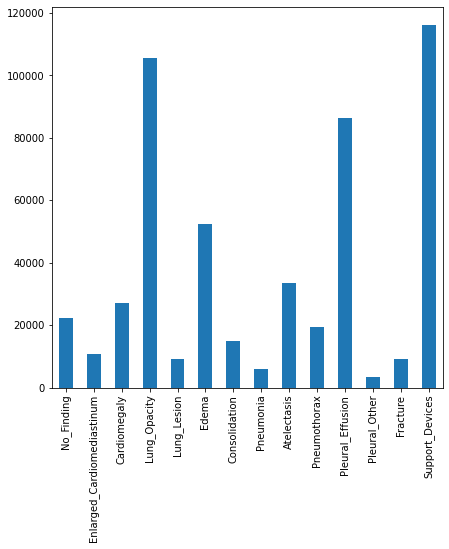

In [46]:
counts = df.sum(axis=0)
counts.plot.bar()

### Models

Since this is a multi-label multi-class problem, each sample can hit multiple classes.    
Hence, all models below use sigmoid activation with binary crossentropy loss.   

Since the classes are highly imbalanced, class weights are used to weight the loss function. Assuming that all of the medical conditions are equally important, we'd ideally like to find weights that equalize the class imbalance, giving more weight to classes that are smaller.        
Let the total number of samples be $T$.   
For a class $i$ with total positive samples $p_i$, the class weight $w_i$ is:
$$ w_i = 1 - \frac{p_i}{d_i}$$
where the denominator $d_i$ is defined as   
$$ d_i = (T-p_i) * m + p_i $$
where $m$ is the class weights multiplication factor.  
Note that when $m=1$, $d_i$ is simply the total counts $T$. Increasing $m$ puts more weight on minor classes.   

#### Model 1

- Architecture: DenseNet 121 $\rightarrow$ Global Average Pooling $\rightarrow$ Dense 
- Final activation: Sigmoid
- Batch size: 32
- Image size: 128
- Class weights multiplication factor: 1
- Epochs: 10

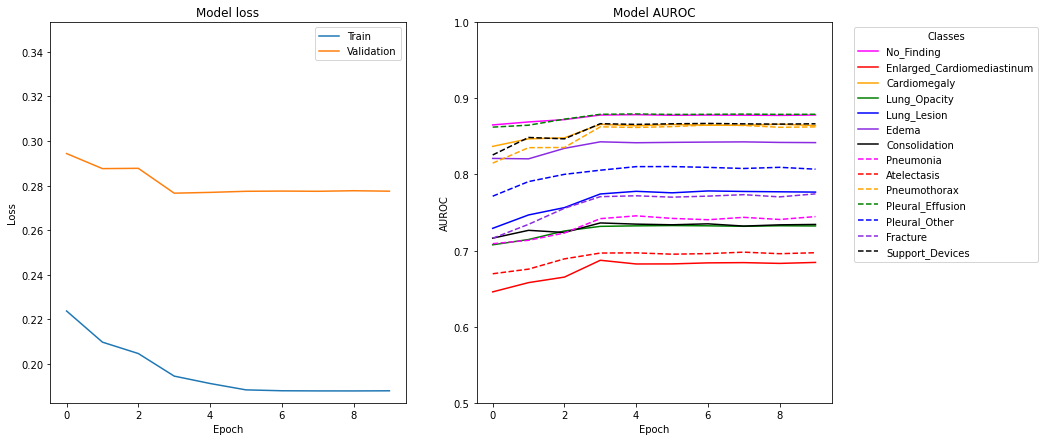

In [47]:
with open('outs/output1/history.pkl' , 'rb') as pickle_file:
    history = pickle.load(pickle_file)
visualize(history, "plots/model1_history.png")

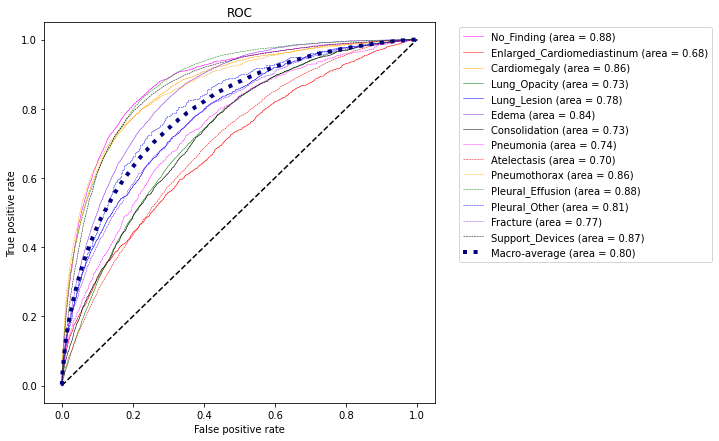

In [51]:
with open('outs/output1/best_preds.pkl' , 'rb') as pickle_file:
    preds = pickle.load(pickle_file)
plotROC(preds, "plots/model1_roc.png")

#### Model 2

- Architecture: DenseNet 169 $\rightarrow$ Global Average Pooling $\rightarrow$ Dense 
- Final activation: Sigmoid
- Batch size: 32
- Image size: 128
- Class weights multiplication factor: 1
- Epochs: 10

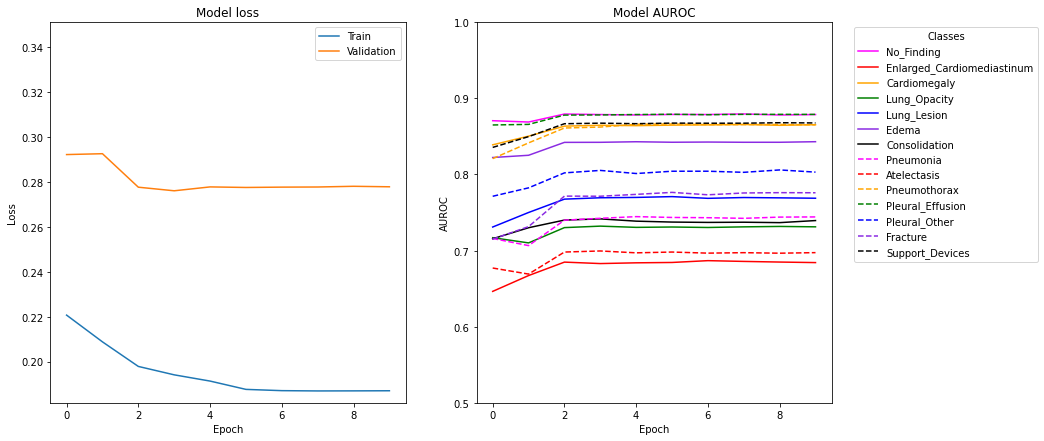

In [49]:
with open('outs/output2/history.pkl' , 'rb') as pickle_file:
    history = pickle.load(pickle_file)
visualize(history, "plots/model2_history.png")

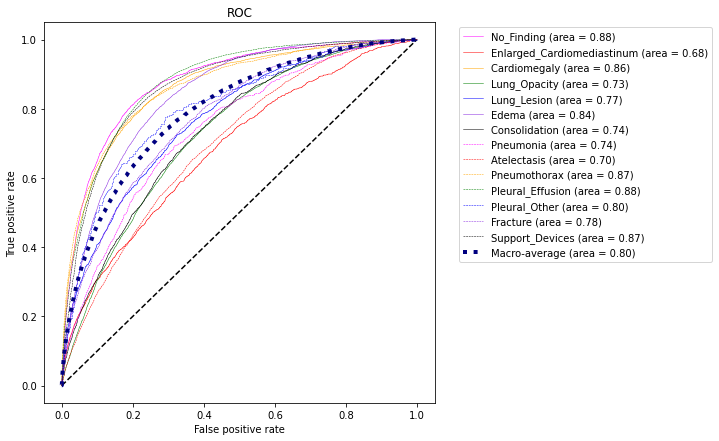

In [52]:
with open('outs/output2/best_preds.pkl' , 'rb') as pickle_file:
    preds = pickle.load(pickle_file)
plotROC(preds, "plots/model2_roc.png")